File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
all_data          Naive Bayes        0.87            0.78            0.7             0.73            1.4291         


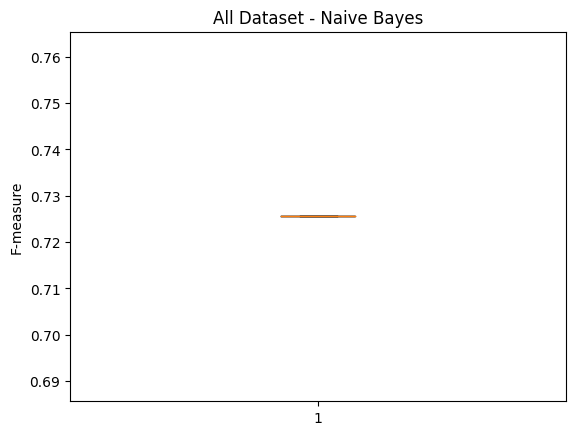

all_data          QDA                0.88            0.81            0.69            0.72            1.4062         


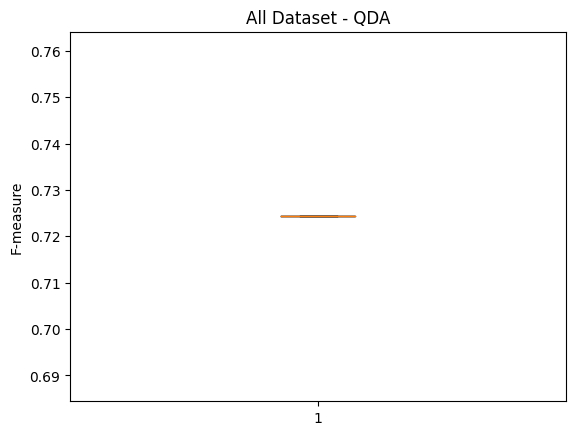

all_data          Random Forest      0.93            0.96            0.8             0.85            8.7074         


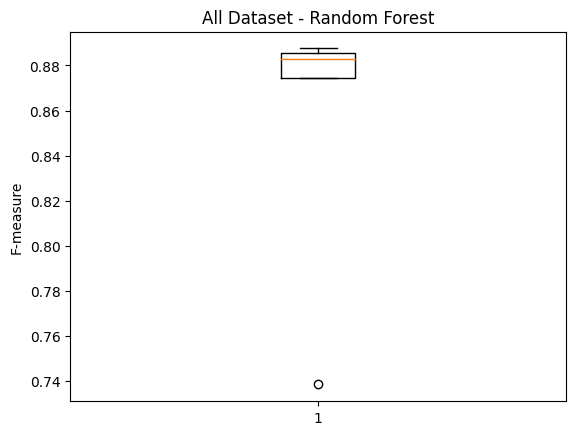

all_data          ID3                0.95            0.93            0.89            0.91            5.0141         


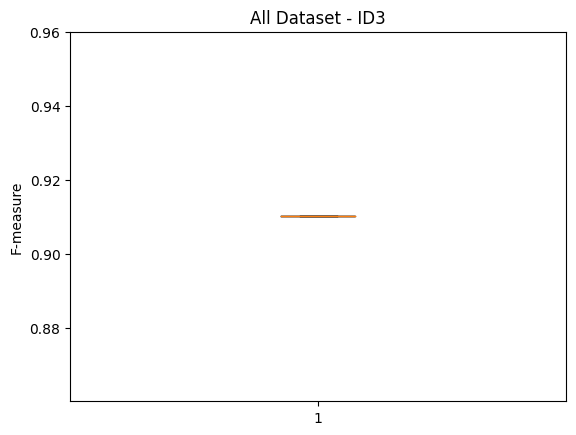

all_data          AdaBoost           0.95            0.93            0.86            0.89            76.1636        


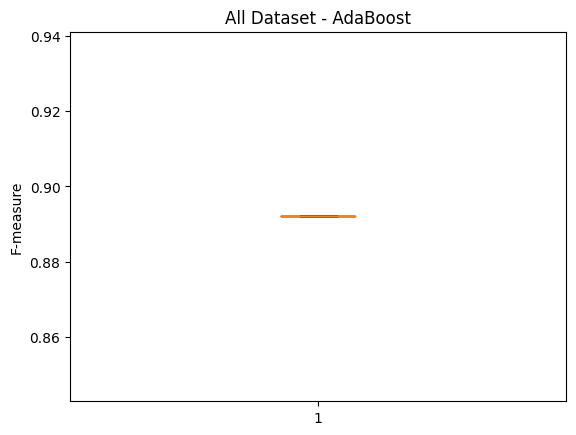

all_data          XGBoost            0.97            0.95            0.95            0.95            42.4934        


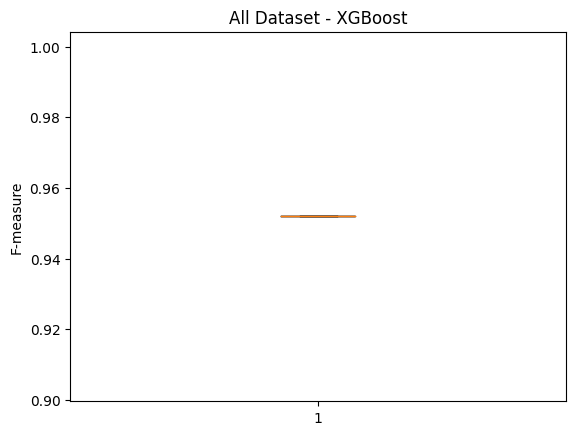

all_data          Ensemble           0.97            0.97            0.93            0.95            295.7585       


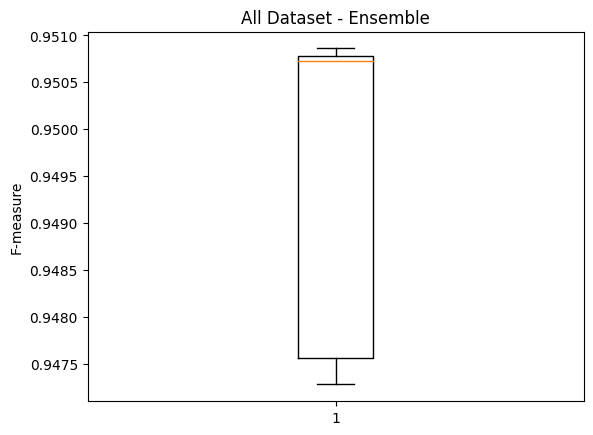

Mission accomplished!
Total operation time: =  2164.126909017563 seconds


In [2]:
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import os
import pandas as pd
import csv
import time
import warnings
import math

warnings.filterwarnings("ignore")

def folder(f_name): 
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print("The folder could not be created!")

result = "./results/results_Final.csv" 
csv_files = ["all_data.csv"] 
path = ""
repetition = 5

folder_name = "./results/"
folder(folder_name)
folder_name = "./results/result_graph_Final/"
folder(folder_name)

usecols = ["Bwd Packet Length Std","Flow Bytes/s","Total Length of Fwd Packets","Fwd Packet Length Std","Flow IAT Std",
"Flow IAT Min","Fwd IAT Total","Flow Duration","Bwd Packet Length Max","Flow IAT Max","Flow IAT Mean","Total Length of Bwd Packets",
"Fwd Packet Length Min","Bwd Packet Length Mean","Flow Packets/s","Fwd Packet Length Mean","Total Backward Packets","Total Fwd Packets",
"Fwd Packet Length Max","Bwd Packet Length Min",'Label']

ml_list = {
"Naive Bayes": GaussianNB(),
"QDA": QDA(),
"Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3": DecisionTreeClassifier(max_depth=5, criterion="entropy"),
"AdaBoost": AdaBoostClassifier(),
"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
"Ensemble": VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)),
    ('ada', AdaBoostClassifier()),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),
    ('xgb', XGBClassifier(random_state=0))
], voting='soft')
}

others = ["Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", "Fwd Packet Length Std",
     "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total"]

algorithms_features = {"Naive Bayes": ['Bwd Packet Length Std', 'Total Length of Fwd Packets', 'Flow IAT Min', 'Fwd Packet Length Min', 'Flow Packets/s', 'Fwd Packet Length Mean'],
"QDA": ['Bwd Packet Length Std', 'Flow Bytes/s', 'Total Length of Fwd Packets', 'Flow IAT Min'], 
"Random Forest": others,
"ID3": others,
"AdaBoost": others,
"Nearest Neighbors": others,
"XGBoost": others,
"Ensemble": others}

seconds = time.time()

with open(result, "w", newline="", encoding="utf-8") as f: 
    wrt = csv.writer(f)
    wrt.writerow(["File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"])

for j in csv_files: 
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time")) 
    feature_list = usecols
    df = pd.read_csv(path + j, usecols = feature_list) 
    df = df.fillna(0)
    attack_or_not = []
    for i in df["Label"]: 
        if i == "BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"] = attack_or_not

    y = df["Label"] 
    del df["Label"]
    feature_list.remove('Label')    
    for ii in ml_list: 
        X = df[algorithms_features[ii]]
        precision = []
        recall = []
        f1 = []
        accuracy = []
        t_time = []
        for i in range(repetition): 
            second = time.time() 

            X_train, X_test, y_train, y_test = train_test_split(X, y, 
                test_size = 0.20, random_state = repetition) 

            clf = ml_list[ii]                                                                          
            clf.fit(X_train, y_train)
            predict = clf.predict(X_test)
        
            f_1 = f1_score(y_test, predict, average='macro')
            pr = precision_score(y_test, predict, average='macro')
            rc = recall_score(y_test, predict, average='macro')

            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time() - second)))

        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4], ii, str(round(np.mean(accuracy), 2)), str(round(np.mean(precision), 2)), 
            str(round(np.mean(recall), 2)), str(round(np.mean(f1), 2)), str(round(np.mean(t_time), 4)))) 

        with open(result, "a", newline="", encoding="utf-8") as f: 
            wrt = csv.writer(f)
            for i in range(0, len(t_time)):
                wrt.writerow([j[0:-4], ii, accuracy[i], precision[i], recall[i], f1[i], t_time[i]]) 

        plt.boxplot(f1)
        plt.title("All Dataset - " + str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name + j[0:-4] + str(ii) + ".pdf", bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
        plt.show() 

    


print("Mission accomplished!")
print("Total operation time: = ", time.time() - seconds, "seconds")
